In [12]:
# Imports cell

import numpy as np
from prospectorFunctions import getSps, getTheta
import itertools
from matplotlib.pyplot import *

In [2]:
# Setting all initial values for models

mass = 1e8 # Just a scaling factor
zred = 3.548 # Exact value of The Cliff

tages = np.linspace(10, 13.6, 5) # (8,9), (7,9)        200Mya-300Myrs
dusts = np.linspace(0,3,10)        # (0, 3) or (0, 4)  
metals = np.linspace(-1,.5,10)     # (-1.0, 0.5)

run_params = {}
run_params['mass'] = mass
run_params['zred'] = zred

run_params['tage'] = tages[0]
run_params['dust2'] = dusts[0]
run_params['logzsol'] = metals[0]

run_params['ldist'] = 10.0
run_params['add_duste'] = False
run_params['snr'] = 10.0
run_params['zcontinuous'] = 1

---------------
# Define all functions
--------

In [3]:
def getModel(mass=None, zred=None, tage=None, logzsol=None, dust2=None, ldist=10.0, add_duste=False, **extras):
    from prospect.models.sedmodel import SedModel
    from prospect.models.templates import TemplateLibrary
    from prospect.models import priors
    
    model_params = TemplateLibrary['parametric_sfh']
    
    # If necessary, this is the step where you would need to change the initial values for the parameters
    model_params['lumdist'] = {'N':1, 'isfree':False, 'init':ldist, 'units':'Mpc'}
    model_params['mass']['isfree'] = False
    model_params['logzsol']['isfree'] = False
    model_params['dust2']['isfree'] = False
    model_params['tage']['isfree'] = False
    model_params['tau']['isfree'] = False
    
    # Variable masses
    if mass == None:
        model_params['mass']['init'] = 1e8
    else:
        model_params['mass']['init'] = mass
        
    # Variable age of the galaxy
    if tage == None:
        model_params['tage']['init'] = 13.
    else:
        model_params['tage']['init'] = tage

    # Variable metallicities
    if logzsol == None:
        model_params['logzsol']['init'] = -0.5
    else:
        model_params['logzsol']['init'] = logzsol

    # Variable dust parameters
    if dust2 == None:
        model_params['dust2']['init'] = 0.05
    else:
        model_params['dust2']['init'] = dust2

    model = SedModel(model_params)
    
    return model

In [4]:
def getObs(snr=10, ldist=10.0, **extras_):

    from prospect.utils.obsutils import fix_obs
    import sedpy
    import numpy as np

    # obs is a dictionary of observational data to use for the fit
    obs = {}

    filternames = ['jwst_f090w', 'jwst_f115w', 'jwst_f150w', 'jwst_f200w', 'jwst_f277w',
                   'jwst_f356w', 'jwst_f410m', 'jwst_f444w', 'jwst_f770w', 'jwst_f1800w']
    obs['filters'] = sedpy.observate.load_filters(filternames)

    ################################################# FIX THE UNITS OF THIS DATA
    M_AB = np.array([0.0148, 0.028, 0.0269, 0.322, 1.090, 1.334, 1.597, 1.725, 1.54, 1.96]) # These are currently in units of microJanskeys (fix)
    ################################################# FIX THE UNITS OF THIS DATA

    # jansky_to_maggie_factor = 3631.0

    dm = 25 + 5.0 * np.log10(ldist)
    mags = M_AB + dm

    obs['maggies'] = 10**(-0.4*mags)
    obs['maggies_unc'] = (1./snr) * obs['maggies']

    obs['phot_wave'] = np.array([f.wave_effective for f in obs['filters']])

    obs['wavelength'] = None
    obs['spectrum'] = None
    obs['unc'] = None
    obs['mask'] = None

    obs = fix_obs(obs)
    
    return obs

In [5]:
def getWave():
    
    wphot = obs['phot_wave']
    
    a = 1.0 + zred
    
    wspec = sps.wavelengths
    wspec *= a
    
    waves = {'wphot':wphot, 'wspec':wspec}
    
    return waves

In [6]:
def getModelPlot(fspec,fphot,vari=None,dust2=None,tage=None,logzsol=None,**extras):
    
#     [mass, zred, tage, dust, logzsol] <- current order of parameter indexing
        
    waves = getWave()
    wspec = waves['wspec']
    wphot = waves['wphot']
    
    if vari == 'dust2':
        val = dust2
    elif vari == 'tage':
        val = tage
    else:
        val = logzsol
    
    loglog(wspec, fspec, label=f'{vari}={round(val,2)}')
    errorbar(wphot, fphot, marker='s', color='gray', alpha=0.8,
             ls='', lw=3, markeredgewidth=3)
    
#     xmin, xmax = bal_break-2e3, bal_break+2e3
    xmin, xmax = np.min(wphot)*0.8, np.max(wphot)/0.8
    temp = np.interp(np.linspace(xmin,xmax,10000), wspec, fspec)
    ymin, ymax = temp.min()*0.8, temp.max()/0.4
    
    store_dict = {'mass':mass,
                  'zred':zred,
                  'tage':tage,
                  'dust2':dust2,
                  'logzsol':logzsol,
                  }

    del store_dict[vari]

    title(store_dict, fontsize=15)
    xlabel('Wavelength [A]', fontsize=15)
    ylabel('Flux Density [maggies]', fontsize=15)
    xlim([xmin, xmax])
    ylim([ymin, ymax])
    xscale('log')
    yscale('log')
    legend(fontsize=15)
    tight_layout()


-----
# Generate model, obs, and sps objects
----

In [7]:
model = getModel(**run_params)
obs = getObs(**run_params)
sps = getSps(**run_params)

In [8]:
# Maybe change fixed_params -> range_params
fixed_params = {}
fixed_params['mass'] = {'init':mass, 'isfree':False}
fixed_params['zred'] = {'init':zred, 'isfree':False}
fixed_params['tage'] = {'range':tages, 'isfree':True}
fixed_params['dust2'] = {'range':dusts, 'isfree':True}       # (0, 3) or (0, 4)
fixed_params['logzsol'] = {'range':metals, 'isfree':True}    # (-1.0, 0.5)

In [9]:
# Initialize data grids to store spectra and the associated parameters

data_grid_params = np.empty((len(tages),len(dusts),len(metals),len(fixed_params.keys())))
data_grid_spec = np.empty((len(tages),len(dusts),len(metals),sps.wavelengths.shape[0]))
data_grid_phot = np.empty((len(tages),len(dusts),len(metals),len(obs['phot_wave'])))

In [10]:
for i_tage,i_dust,i_metal in itertools.product(range(len(tages)), range(len(dusts)), range(len(metals))):
    
    tage = tages[i_tage]
    dust = dusts[i_dust]
    metal = metals[i_metal]
    
    run_params['tage'] = tage
    run_params['dust2'] = dust
    run_params['logzsol'] = metal
    
    model = getModel(**run_params)
    init_spec, init_phot, init_mfrac = getTheta(model, obs, sps)
    
    data_grid_params[i_tage, i_dust, i_metal, :] = [mass, zred, tage, dust, metal]
    data_grid_spec[i_tage, i_dust, i_metal, :] = init_spec
    data_grid_phot[i_tage, i_dust, i_metal, :] = init_phot

----------
# Make plots over range for each parameter
----------

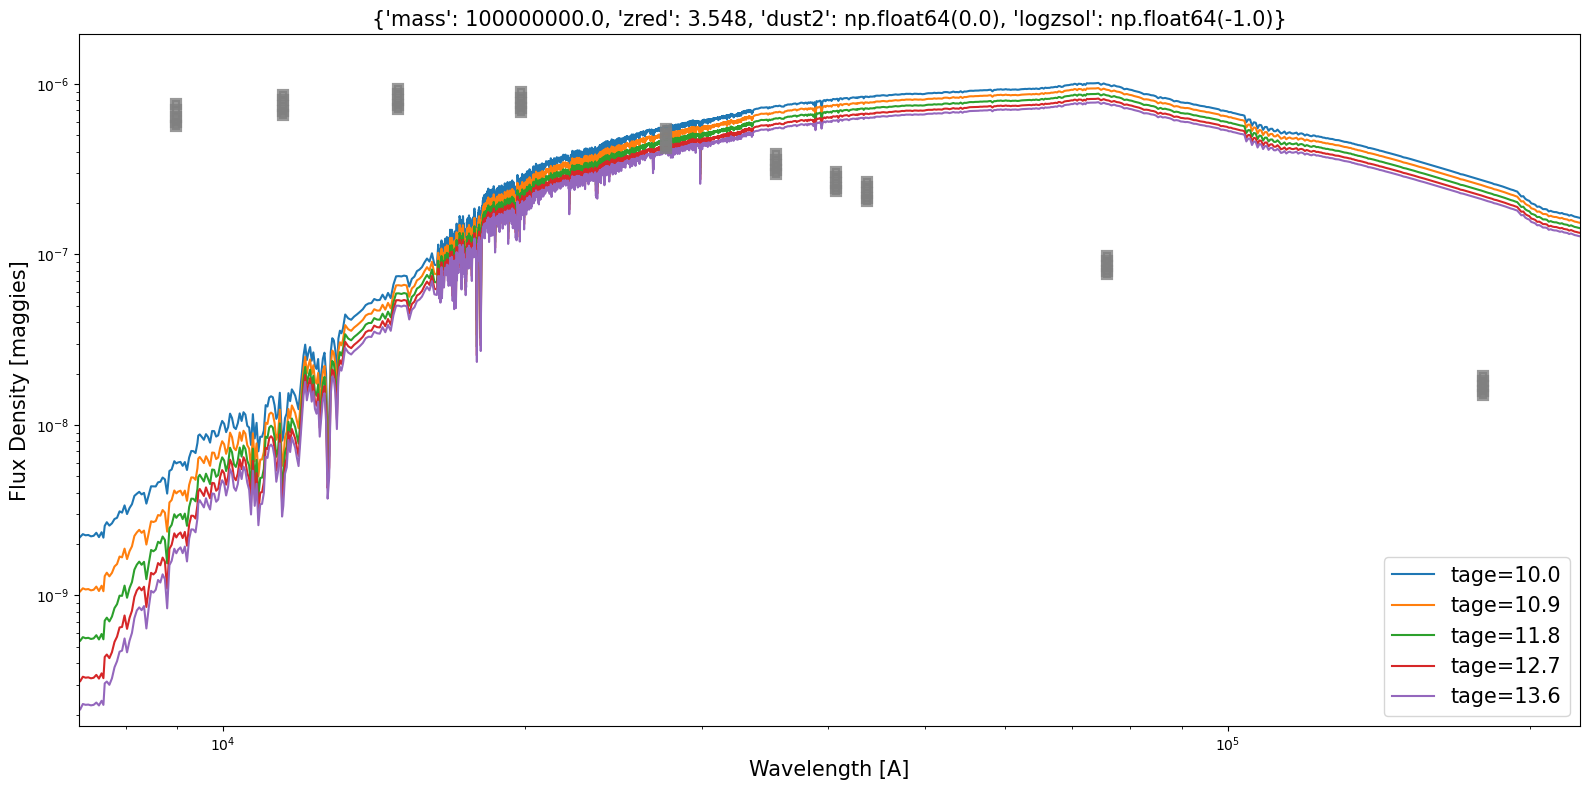

In [13]:
# Plotting across range of tages

figure(figsize=(16,8))

extras = {}
extras['vari'] = 'tage'

t,d,Z = 0,0,0

for t in range(len(tages)):

    m,z,tage,dust,metal = data_grid_params[t,d,Z,:]

    extras['tage'] = tage
    extras['dust2'] = dust
    extras['logzsol'] = metal

    fspec = data_grid_spec[t,d,Z,:]
    fphot = data_grid_phot[t,d,Z,:]

    getModelPlot(fspec, fphot, **extras)
    
show()

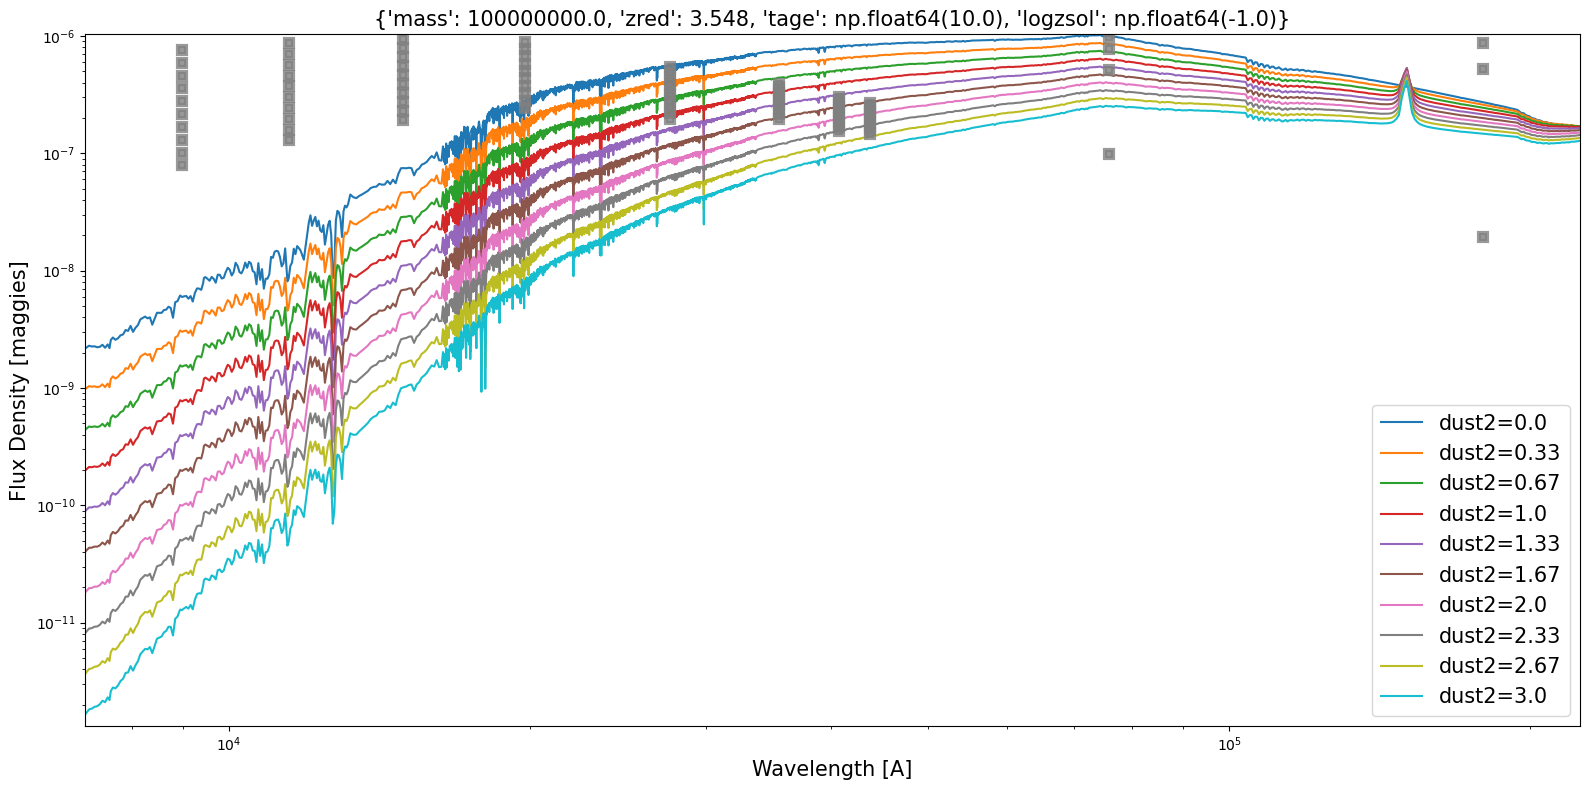

In [14]:
# Plotting over range of dusts

figure(figsize=(16,8))

extras = {}
extras['vari'] = 'dust2'

t,d,Z = 0,0,0

for d in range(len(dusts)):

    m,z,tage,dust,metal = data_grid_params[t,d,Z,:]

    extras['tage'] = tage
    extras['dust2'] = dust
    extras['logzsol'] = metal
    
    fspec = data_grid_spec[t,d,Z,:]
    fphot = data_grid_phot[t,d,Z,:]

    getModelPlot(fspec, fphot, **extras)
    
show()

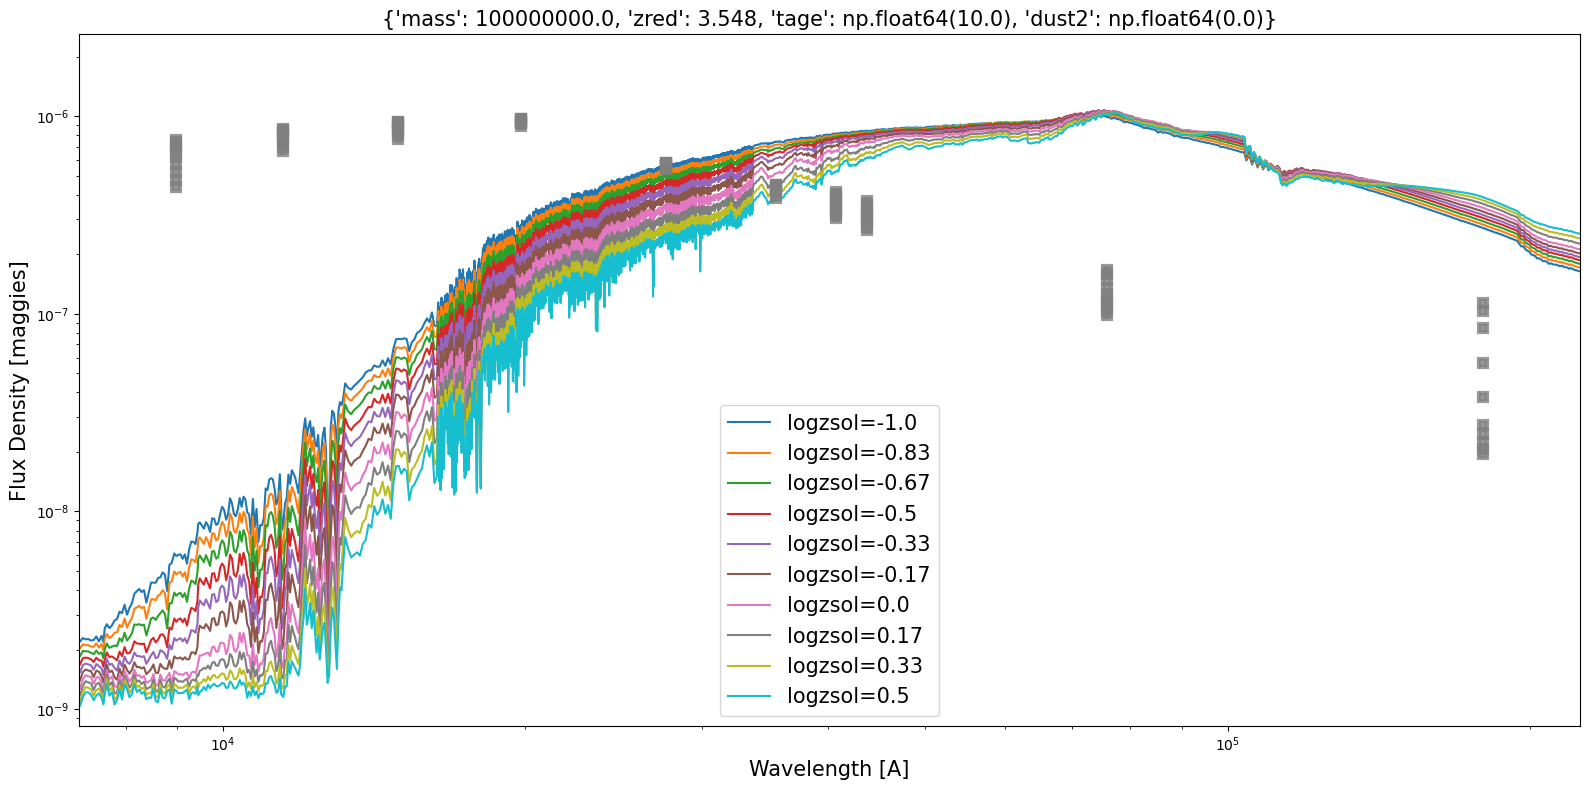

In [15]:
# Plotting over range of metallicities

figure(figsize=(16,8))

extras = {}
extras['vari'] = 'logzsol'

t,d,Z = 0,0,0

for Z in range(len(metals)):

    m,z,tage,dust,metal = data_grid_params[t,d,Z,:]

    extras['tage'] = tage
    extras['dust2'] = dust
    extras['logzsol'] = metal

    fspec = data_grid_spec[t,d,Z,:]
    fphot = data_grid_phot[t,d,Z,:]

    getModelPlot(fspec, fphot, **extras)
    
show()

In [16]:
waves = getWave()
wphot = waves['wphot']
xmin, xmax = np.min(wphot)*0.8, np.max(wphot)/0.8
print(xmin, xmax)

7186.060443065788 224238.66119795354


In [17]:
waves = getWave()
wphot = waves['wphot']

bal_break = (zred+1)*3646

xmin, xmax = bal_break-2e3, bal_break+2e3
print(xmin, xmax)

14582.008000000002 18582.008


In [18]:
(zred+1)*3646

16582.008